# Теория

https://scikit-learn.org/stable/modules/tree.html

## Советы по практическому использованию

Деревья решений имеют тенденцию перехватывать данные с большим количеством функций. 
Очень важно получить правильное соотношение выборок к количеству признаков, 
поскольку дерево с небольшим количеством выборок в многомерном пространстве 
с большой вероятностью будет переобучено.

Подумайте о том, чтобы заранее выполнить уменьшение размерности (`PCA`, `ICA` или выбор функций),
чтобы дать вашему дереву больше шансов найти отличительные признаки.

Понимание структуры дерева решений поможет получить более глубокое представление о том, 
как дерево решений делает прогнозы, что важно для понимания важных особенностей данных.

Визуализируйте свое дерево во время обучения, используя эту export функцию. 
Используйте `max_depth=3` в качестве начальной глубины дерева, чтобы понять, 
насколько дерево соответствует вашим данным, а затем увеличьте глубину.

Помните, что количество образцов, необходимых для заполнения дерева, удваивается для 
каждого дополнительного уровня, до которого дерево растет. 
*Используйте `max_depth` для управления размером дерева во избежание переобучения.*

Используйте `min_samples_split` или `min_samples_leaf`, чтобы гарантировать, 
что несколько выборок учитывают каждое решение в дереве, контролируя, какие 
разделения будут учитываться. Очень маленькое число обычно означает, что дерево 
переобучится, тогда как большое число не позволит дереву изучить данные. 
Попробуйте `min_samples_leaf=5` в качестве начального значения. 
Если размер выборки сильно различается, в этих двух параметрах можно использовать 
число с плавающей запятой в процентах. Хотя `min_samples_split` можно создавать 
листья произвольного размера, `min_samples_leaf` гарантирует, что каждый лист 
имеет минимальный размер, избегая узлов с низкой дисперсией и переподгонкой в 
задачах регрессии. Для классификации с небольшим количеством классов 
`min_samples_leaf=1` часто это лучший выбор.

Обратите внимание, что `min_samples_split` выборки рассматриваются напрямую и 
независимо от `sample_weight`, если они предусмотрены (например, узел с m 
взвешенными выборками по-прежнему считается имеющим ровно m выборок). 
Рассмотрите `min_weight_fraction_leaf` или `min_impurity_decrease`
необходимость учета веса выборки при разделении.

*Сбалансируйте* свой набор данных перед тренировкой, чтобы дерево не было смещено 
в сторону доминирующих классов. Балансировку классов можно выполнить путем 
выборки равного количества выборок из каждого класса или, что предпочтительнее, 
путем нормализации суммы весов выборки (`sample_weight`) для каждого класса к 
одному и тому же значению. Также обратите внимание, что критерии предварительного 
сокращения на основе веса, такие как `min_weight_fraction_leaf`, будут тогда менее 
смещены в сторону доминирующих классов, чем критерии, которые не учитывают веса 
выборки, например `min_samples_leaf`.

Если выборки взвешены, будет проще оптимизировать древовидную структуру, 
используя критерий предварительного сокращения на основе веса, такой как 
`min_weight_fraction_leaf`, который гарантирует, что конечные узлы содержат 
хотя бы часть общей суммы весов выборки.

Все деревья решений `np.float32` внутренне используют массивы. 
Если данные обучения не в этом формате, будет создана копия набора данных.

Если входная матрица X очень разрежена, рекомендуется преобразовать ее в 
разреженную `csc_matrix` перед вызовом функции `fit` и разреженную `csr_matrix` 
перед вызовом предсказания. Время обучения может быть на несколько порядков 
быстрее для входных разреженных матриц по сравнению с плотной матрицей, 
когда признаки имеют нулевые значения в большинстве выборок.


## Поддержка отсутствующих значений

DecisionTreeClassifier и DecisionTreeRegressor имеют встроенную поддержку отсутствующих 
значений, когда `splitter='best'` и критерием является `gini`, `entropy` или `log_loss`, 
для классификации или `squared_error`, `friedman_mse`, или `poisson` для регрессии.

Для каждого потенциального порога непропущенных данных разделитель оценит разделение, 
при этом все пропущенные значения перейдут в левый или правый узел.

Решения принимаются следующим образом:

- По умолчанию при прогнозировании выборки с пропущенными значениями классифицируются 
по классу, используемому в разбиении, обнаруженном во время обучения.
- Если оценка критерия одинакова для обоих узлов, то связь для отсутствующего значения 
во время прогнозирования прерывается путем перехода к правильному узлу. 
Разделитель также проверяет разделение, при котором все пропущенные значения передаются 
одному дочернему элементу, а непропущенные значения — другому
- Если во время обучения для данного признака не обнаружено пропущенных значений, 
то во время прогнозирования недостающие значения сопоставляются дочернему элементу 
с наибольшим количеством выборок

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, LabelEncoder
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn import tree


# Загрузка данных

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
credit_approval = fetch_ucirepo(id=27) 
  
# data (as pandas dataframes) 
X = credit_approval.data.features 
y = credit_approval.data.targets 
  
# metadata 
print(credit_approval.metadata) 
  
# variable information 
print(credit_approval.variables) 


{'uci_id': 27, 'name': 'Credit Approval', 'repository_url': 'https://archive.ics.uci.edu/dataset/27/credit+approval', 'data_url': 'https://archive.ics.uci.edu/static/public/27/data.csv', 'abstract': 'This data concerns credit card applications; good mix of attributes', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 690, 'num_features': 15, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['A16'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1987, 'last_updated': 'Wed Aug 23 2023', 'dataset_doi': '10.24432/C5FS30', 'creators': ['J. R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This file concerns credit card applications.  All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data.\r\n  \r\nThis dataset is interesting because there is a good mix of attributes --

FEATURES:
A1:	    b, a.
A2:	    continuous.
A3:	    continuous.
A4:	    u, y, l, t.
A5:	    g, p, gg.
A6:	    c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
A7:	    v, h, bb, j, n, z, dd, ff, o.
A8:	    continuous.
A9:	    t, f.
A10:	t, f.
A11:	continuous.
A12:	t, f.
A13:	g, p, s.
A14:	continuous.
A15:	continuous.

TARGET
A16:    +,- (class attribute)

In [3]:
num_features = ["A2", "A3", "A8", "A11", "A14", "A15"]
cat_features = ["A1", "A4", "A5", "A6", "A7", "A9", "A10", "A12", "A13"]
target = ["A16"]

# Анализ данных

In [4]:
X.head()

,A15,A14,A13,A12,A11,A10,A9,A8,A7,A6,A5,A4,A3,A2,A1
0,0,202.0,g,f,1,t,t,1.25,v,w,g,u,0.000,30.83,b
1,560,43.0,g,f,6,t,t,3.04,h,q,g,u,4.460,58.67,a
2,824,280.0,g,f,0,f,t,1.50,h,q,g,u,0.500,24.50,a
3,3,100.0,g,t,5,t,t,3.75,v,w,g,u,1.540,27.83,b
4,0,120.0,s,f,0,f,t,1.71,v,w,g,u,5.625,20.17,b


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A15     690 non-null    int64  
 1   A14     677 non-null    float64
 2   A13     690 non-null    object 
 3   A12     690 non-null    object 
 4   A11     690 non-null    int64  
 5   A10     690 non-null    object 
 6   A9      690 non-null    object 
 7   A8      690 non-null    float64
 8   A7      681 non-null    object 
 9   A6      681 non-null    object 
 10  A5      684 non-null    object 
 11  A4      684 non-null    object 
 12  A3      690 non-null    float64
 13  A2      678 non-null    float64
 14  A1      678 non-null    object 
dtypes: float64(4), int64(2), object(9)
memory usage: 81.0+ KB


Некоторые признаки имеют пропущенные значения. 
Посмотрим сколько экземпляров имеют хотя бы одно.  

In [6]:
na_mask = X.isna().any(axis=1)
na_mask.value_counts()

False    653
True      37
Name: count, dtype: int64

37 записей имеют хотя бы одно пропущенное значение. Это 5% от нашего дата-сета.

Все наши фичи закодированы с целью защиты персональных данных и совершенно
нельзя понять что конкретно какая из них обозначает. Соответственно, мы
не можем знать насколько важна та или иная фича для результата и как может 
отразиться на нем пустое значение. 
 
С одной стороны, 5% - это не много и можно было бы удалить эти строки, 
с другой стороны, деревья могут обрабатывать пропущенные значения, поэтому 
пока оставим все как есть, но сохраним индексы этих записей на будущее.

In [7]:
na_idx = X[na_mask].index
na_idx

Index([ 71,  83,  86,  92,  97, 202, 206, 243, 248, 254, 270, 278, 286, 327,
       329, 330, 346, 374, 406, 445, 450, 453, 456, 479, 489, 500, 515, 520,
       539, 592, 598, 601, 608, 622, 626, 641, 673],
      dtype='int64')

Посмотрим на числовые и категориальные признаки отдельно

In [8]:
X[num_features].describe()

,A2,A3,A8,A11,A14,A15
count,678.000000,690.000000,690.000000,690.00000,677.000000,690.000000
mean,31.568171,4.758725,2.223406,2.40000,184.014771,1017.385507
std,11.957862,4.978163,3.346513,4.86294,173.806768,5210.102598
min,13.750000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,22.602500,1.000000,0.165000,0.00000,75.000000,0.000000
50%,28.460000,2.750000,1.000000,0.00000,160.000000,5.000000
75%,38.230000,7.207500,2.625000,3.00000,276.000000,395.500000
max,80.250000,28.000000,28.500000,67.00000,2000.000000,100000.000000


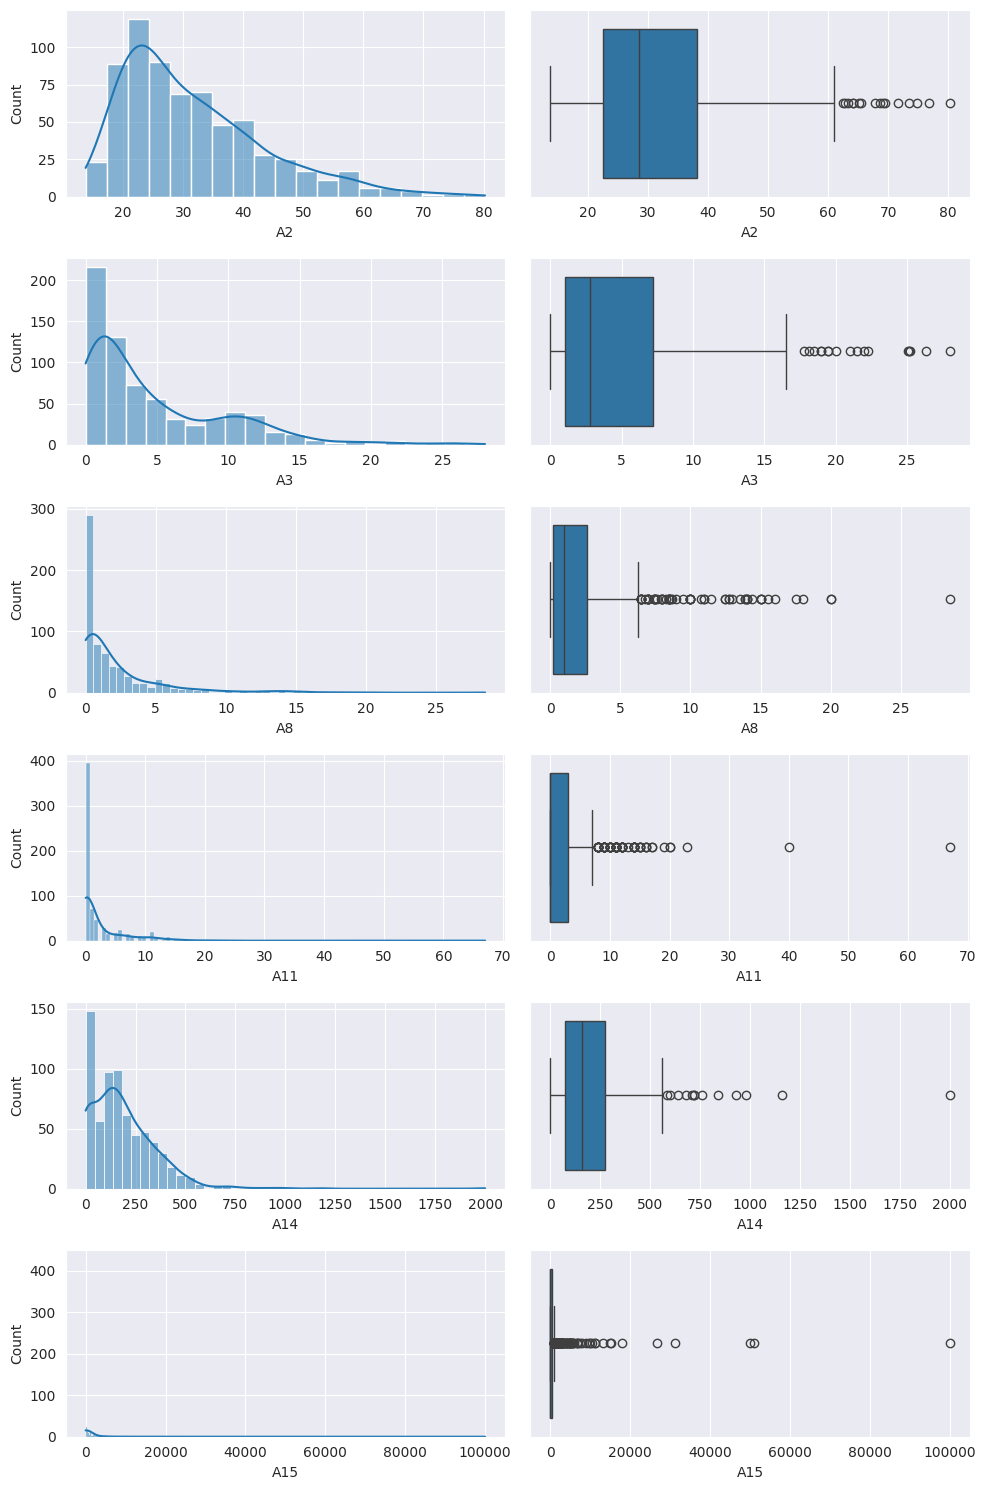

In [9]:
n_rows = len(num_features)
n_cols = 2
_, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 15))

for idx, feature in enumerate(num_features):
    sns.histplot(data=X, x=feature, kde=True, ax=axes[idx, 0])
    sns.boxplot(data=X, x=feature, ax=axes[idx, 1])
    # axs[row][col].set_title(feature)
    
plt.tight_layout()
plt.show()

Распределение не нормальное, все признаки имеют выбросы. 
Деревья решений устойчивы к выбросам и не требуют масштабирования
Поэтому предложение оставить данные как есть. 

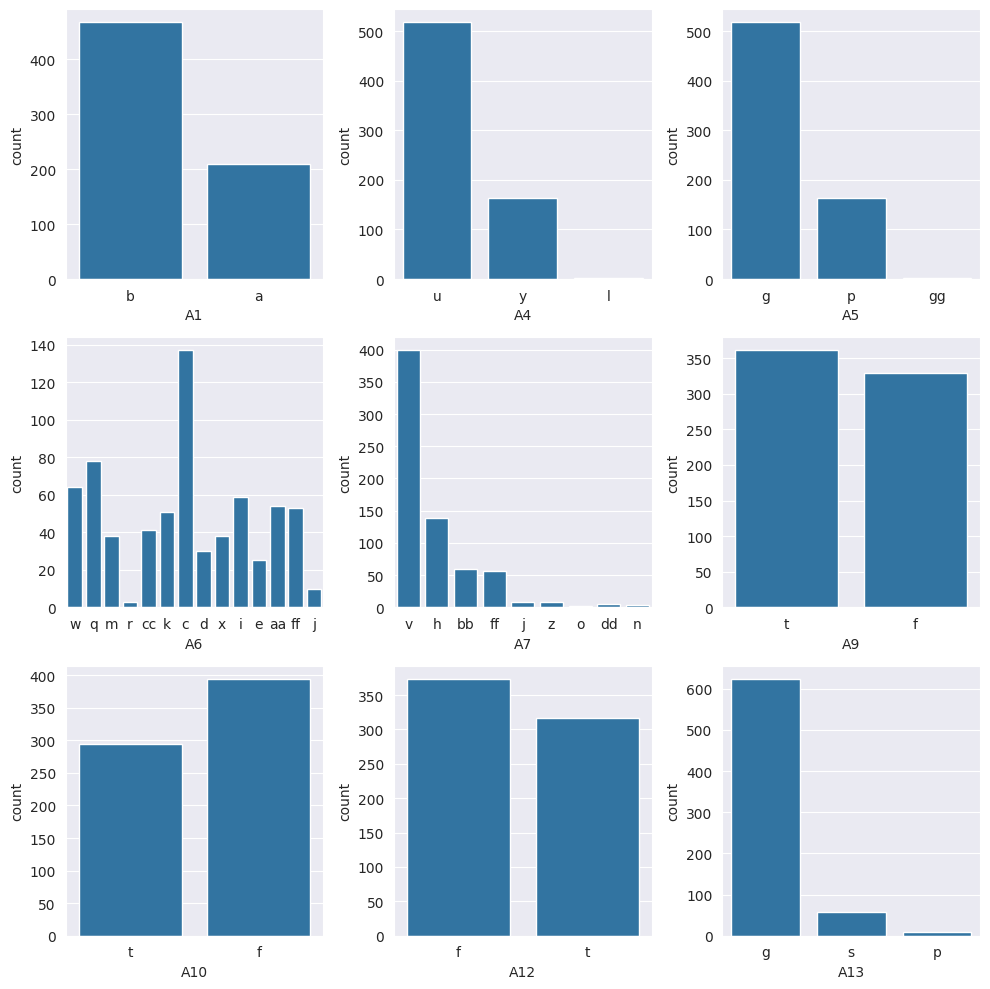

In [10]:
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for idx, feature in enumerate(cat_features):
    ax = axes[idx // 3, idx % 3]
    sns.countplot(data=X, x=feature, ax=ax)
    # axs[row][col].set_title(feature)
    
plt.tight_layout()
plt.show()

Опять же, не зная, не понимая что это за фичи, сложно как-то осмысленно это комментировать.
Есть дисбаланс по некоторым признакам, но это не таргет, поэтому не имеет значения (или имеет?)

Подозреваю, что t и f в фичах A9, A10, A12 - это True и False, но это не точно.
Реализация деревьев в sklearn не поддерживает работу с категориальными фичами, 
поэтому отдадим это на усмотрение `OneHotEncoder`.

Посмотрим на таргет

In [11]:
y.head()

,A16
0,+
1,+
2,+
3,+
4,+


In [12]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   A16     690 non-null    object
dtypes: object(1)
memory usage: 5.5+ KB


In [13]:
y.value_counts()

A16
-      383
+      307
Name: count, dtype: int64

<Axes: xlabel='A16', ylabel='count'>

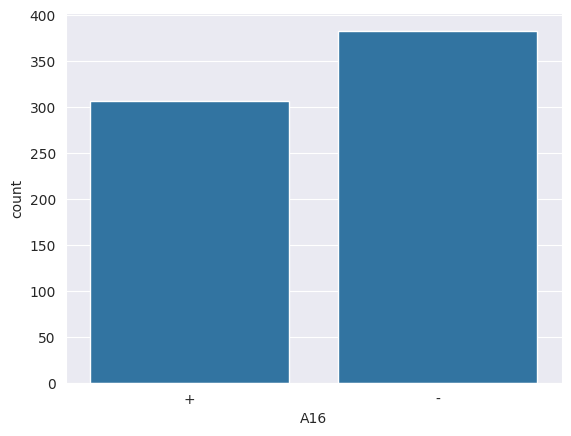

In [14]:
sns.countplot(data=y, x="A16")

По таргету пропусков нет, выборка сбалансирована по целевому классу, заметного дисбаланса нет.

# Подготовка данных

Переведем наши категоримальные фичи в цифры. Для таргета используем `OrdinalEncoder`, для фич - `OneHotEncoder`
Воспользуемся энкодерами из библиотеки `category_encoders` т.к. они более удобные чем штатные sklearn

In [15]:
replace_dict = {'-':0, '+':1}
encoder = OrdinalEncoder(mapping=[{"col": "A16",
                                   "mapping": replace_dict}, ])
y_ = encoder.fit_transform(y)
y_.head()

,A16
0,1
1,1
2,1
3,1
4,1


In [16]:
encoder = OneHotEncoder()
X_ = encoder.fit_transform(X)
X_.head()

,A15,A14,A13_1,A13_2,A13_3,A12_1,A12_2,A11,A10_1,A10_2,...,A5_4,A4_1,A4_2,A4_3,A4_4,A3,A2,A1_1,A1_2,A1_3
0,0,202.0,1,0,0,1,0,1,1,0,...,0,1,0,0,0,0.000,30.83,1,0,0
1,560,43.0,1,0,0,1,0,6,1,0,...,0,1,0,0,0,4.460,58.67,0,1,0
2,824,280.0,1,0,0,1,0,0,0,1,...,0,1,0,0,0,0.500,24.50,0,1,0
3,3,100.0,1,0,0,0,1,5,1,0,...,0,1,0,0,0,1.540,27.83,1,0,0
4,0,120.0,0,1,0,1,0,0,0,1,...,0,1,0,0,0,5.625,20.17,1,0,0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=42)

# Построение дерева, оценка результата

In [18]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

[Text(0.5, 0.875, 'x[10] <= 0.5\ngini = 0.491\nsamples = 483\nvalue = [273, 210]'),
 Text(0.25, 0.625, 'x[1] <= 425.5\ngini = 0.119\nsamples = 236\nvalue = [221, 15]'),
 Text(0.125, 0.375, 'x[33] <= 0.5\ngini = 0.063\nsamples = 215\nvalue = [208, 7]'),
 Text(0.0625, 0.125, 'gini = 0.064\nsamples = 208\nvalue = [201, 7]'),
 Text(0.1875, 0.125, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(0.375, 0.375, 'x[2] <= 0.5\ngini = 0.472\nsamples = 21\nvalue = [13, 8]'),
 Text(0.3125, 0.125, 'gini = 0.346\nsamples = 9\nvalue = [2, 7]'),
 Text(0.4375, 0.125, 'gini = 0.153\nsamples = 12\nvalue = [11, 1]'),
 Text(0.75, 0.625, 'x[9] <= 0.5\ngini = 0.332\nsamples = 247\nvalue = [52, 195]'),
 Text(0.625, 0.375, 'x[28] <= 0.5\ngini = 0.188\nsamples = 160\nvalue = [16, 144]'),
 Text(0.5625, 0.125, 'gini = 0.155\nsamples = 152\nvalue = [13, 139]'),
 Text(0.6875, 0.125, 'gini = 0.5\nsamples = 8\nvalue = [3, 5]'),
 Text(0.875, 0.375, 'x[1] <= 96.0\ngini = 0.484\nsamples = 87\nvalue = [36, 51]'),
 Text(

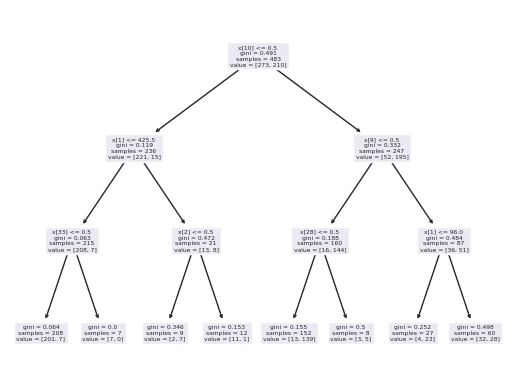

In [19]:
tree.plot_tree(model)

In [20]:
y_train_predicted = model.predict(X_train)
print("TRAIN data\n",
      classification_report(y_true=y_train, y_pred=y_train_predicted, zero_division=0))

y_test_predicted = model.predict(X_test)
print("TEST data\n",
      classification_report(y_true=y_test, y_pred=y_test_predicted, zero_division=0))

TRAIN data
               precision    recall  f1-score   support

           0       0.87      0.92      0.90       273
           1       0.89      0.83      0.86       210

    accuracy                           0.88       483
   macro avg       0.88      0.87      0.88       483
weighted avg       0.88      0.88      0.88       483

TEST data
               precision    recall  f1-score   support

           0       0.80      0.91      0.85       110
           1       0.88      0.74      0.80        97

    accuracy                           0.83       207
   macro avg       0.84      0.83      0.83       207
weighted avg       0.84      0.83      0.83       207


In [21]:
model.n_features_in_

51

In [22]:
model.feature_importances_[model.feature_importances_ != 0]

array([0.06524472, 0.03201728, 0.06392423, 0.8209895 , 0.0165263 ,
       0.00129797])

In [23]:
model.feature_names_in_[model.feature_importances_ != 0]

array(['A14', 'A13_1', 'A10_2', 'A9_1', 'A6_6', 'A6_11'], dtype=object)

Хорошие показатели на обучающей и на тестовой выборках даже без подбора гиперпараметров.
При этом видим, что во время обучение наше дерево увидело все 51 фичи (с учетом работы OneHotEncoder), 
но значимыми из них были только 6

# Подбор гиперпараметров

In [24]:
model = DecisionTreeClassifier(random_state=42)

tree_parameters = {
    "max_depth": range(1, 20),
    "min_samples_leaf": range(1, 10),
    "max_features": [0.5, 0.7, 1, "sqrt", "log2"],
}

cv_model = GridSearchCV(model, param_grid= tree_parameters, cv=5, scoring="roc_auc").fit(X_train, y_train)
model = cv_model.best_estimator_
model

DecisionTreeClassifier(max_depth=4, max_features=0.5, min_samples_leaf=8,
                       random_state=42)

In [25]:
y_train_predicted = model.predict(X_train)
print("TRAIN data\n",
      classification_report(y_true=y_train, y_pred=y_train_predicted, zero_division=0))

y_test_predicted = model.predict(X_test)
print("TEST data\n",
      classification_report(y_true=y_test, y_pred=y_test_predicted, zero_division=0))

TRAIN data
               precision    recall  f1-score   support

           0       0.93      0.84      0.88       273
           1       0.81      0.91      0.86       210

    accuracy                           0.87       483
   macro avg       0.87      0.88      0.87       483
weighted avg       0.88      0.87      0.87       483

TEST data
               precision    recall  f1-score   support

           0       0.90      0.79      0.84       110
           1       0.79      0.90      0.84        97

    accuracy                           0.84       207
   macro avg       0.84      0.84      0.84       207
weighted avg       0.85      0.84      0.84       207


После подбора гипер-параметров модель незначительно улучшила метрики

In [26]:
model.feature_importances_[model.feature_importances_ != 0]

array([8.21188285e-04, 3.02301485e-02, 7.22406532e-02, 8.27913943e-01,
       2.18734308e-02, 3.81425955e-03, 1.25929787e-02, 7.84203097e-04,
       1.20253216e-02, 2.83390467e-03, 1.48699682e-02])

В этот раз значимых фич оказалось 10 из 51

# Сравнение с другими видами классификации

## Подготовка данных

Сравним перформанс нашего дерева с логистической регрессией и метрической моделью.
Для этого нам сначала следует решить вопрос с пустыми значениями и выполнить масштабирование данных.

In [27]:
inputer = SimpleImputer(strategy='median')
X_ = inputer.fit_transform(X_)

In [28]:
# scaler = QuantileTransformer(output_distribution="normal", random_state=42)
scaler = PowerTransformer(method="yeo-johnson", standardize=True)
# scaler = RobustScaler(with_centering=True, with_scaling=True)

X_ = scaler.fit_transform(X_)
y_ = y_.to_numpy().ravel()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=42)

## Logistic Regression

In [30]:
model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)

y_train_predicted = model.predict(X_train)
print("TRAIN data\n",
      classification_report(y_true=y_train, y_pred=y_train_predicted, zero_division=0))

y_test_predicted = model.predict(X_test)
print("TEST data\n",
      classification_report(y_true=y_test, y_pred=y_test_predicted, zero_division=0))

TRAIN data
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       273
           1       0.86      0.90      0.88       210

    accuracy                           0.89       483
   macro avg       0.89      0.89      0.89       483
weighted avg       0.89      0.89      0.89       483

TEST data
               precision    recall  f1-score   support

           0       0.87      0.83      0.85       110
           1       0.81      0.86      0.83        97

    accuracy                           0.84       207
   macro avg       0.84      0.84      0.84       207
weighted avg       0.84      0.84      0.84       207


## Metric model

In [31]:
model = KNeighborsClassifier()

model.fit(X_train, y_train)

y_train_predicted = model.predict(X_train)
print("TRAIN data\n",
      classification_report(y_true=y_train, y_pred=y_train_predicted, zero_division=0))

y_test_predicted = model.predict(X_test)
print("TEST data\n",
      classification_report(y_true=y_test, y_pred=y_test_predicted, zero_division=0))

TRAIN data
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       273
           1       0.89      0.84      0.86       210

    accuracy                           0.89       483
   macro avg       0.89      0.88      0.88       483
weighted avg       0.89      0.89      0.89       483

TEST data
               precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.83      0.80      0.82        97

    accuracy                           0.83       207
   macro avg       0.83      0.83      0.83       207
weighted avg       0.83      0.83      0.83       207


# Резюме
Все 3 модели показали на данном дата сете хорошие результаты
Accuracy на тестовой выборке на уровне 0.83 - 0.84 

Но при этом деревья не требуют никакой подготовки данных, 
кроме кодирования категориальных признаков 